### **PART IV: Compare Flood Extent to Vulnerability**
Use flood per tract to plot Lorenz Curves and calculate Gini coefficients.

In [1]:
# Import packages
import os
import rasterio as rio
from rasterio.plot import show
#import rioxarray as rxr
import geopandas as gpd
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # for rectangle in tracts fig

In [2]:
os.getcwd()

'c:\\Users\\rcompos\\OneDrive - North Carolina State University\\Documents\\Research\\Scripts\\Scripts_use_floods_take_2_bb'

In [4]:
# paths
#flood_tr_path = 'data\\flood_per_tract104.csv'
flood_tr_path = 'data\\flood_per_tract624.csv'
svi_path = 'data\\Pennsylvania.csv'
zone_area_path ='data\\zones_area.csv'

# read in data
fl_tra = pd.read_csv(flood_tr_path)
svi_big = pd.read_csv(svi_path)
zone_a = pd.read_csv(zone_area_path)

In [5]:
# prepare svi
# filter to desired counties
svi = svi_big[(svi_big['COUNTY']=='Philadelphia') | (svi_big['COUNTY']=='Montgomery') | (svi_big['COUNTY']=='Bucks') 
              | (svi_big['COUNTY']=='Delaware')]

# select desired columns
cols = ['COUNTY','FIPS','E_TOTPOP','E_POV150','E_AGE65','E_DISABL','E_MINRTY', 'EP_POV150','E_LIMENG',
        'RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4',
        'SPL_THEME1','SPL_THEME2','SPL_THEME3','SPL_THEME4',
        'SPL_THEMES', 'RPL_THEMES'] # spl = sum of all the themes and percentile rank of all themes
svi = svi[cols]

In [6]:
fl_tra.columns

Index(['FIPS', 'area_100_fzt', 'area_500_fzt', 'area_min_fzt', 'area_ot_fzt',
       'area_fl_tra', 'area_100_km', 'area_500_km', 'area_min_km',
       'area_ot_km', 'area_fl_km', 'per_fl_100', 'per_fl_500', 'per_fl_min',
       'per_fl_ot', 'STCNTY', 'COUNTY', 'geometry', 'area_tract',
       'per_fl_tra'],
      dtype='object')

In [7]:
# prepare flood data
# remove columns (so no duplicate cnty when merge)
fl_t = fl_tra.drop(columns = ['COUNTY','geometry','STCNTY','area_tract'])


In [8]:
# merge data
combo = svi.merge(fl_t,how='left',on='FIPS').merge(zone_a,how='left',on='FIPS')
len(combo)
#combo.groupby(['COUNTY_x']).size()

# fill in nas
combo.fillna(0,inplace=True)

In [9]:
# make flood exposure column
combo['exposure']=combo['E_TOTPOP']*combo['area_fl_tra'] # calculate exposed population
combo['exp_km']=combo['E_TOTPOP']*combo['area_fl_km'] 
combo['exp_per']=combo['E_TOTPOP']*combo['per_fl_tra'] 

In [10]:
# define function for calculating gini index from lorenz curve
# source - https://www.geeksforgeeks.org/lorenz-curve-meaning-construction-and-application/

def gini_from_lorenz(lorenz_curve):
    area_under_curve = np.trapz(lorenz_curve, dx=1.0 / len(lorenz_curve))
    area_perfect_equality = 0.5  # The area under the line of perfect equality (diagonal)
    gini_index = (area_perfect_equality - area_under_curve) / area_perfect_equality
    return gini_index

In [11]:
combo['per_pov'] = combo['E_POV150'].div(combo['E_TOTPOP'])
combo['fake_income'] = np.random.randint(50000,150000, size=len(combo))

(array([ 91.,  96.,  87., 100.,  97., 100.,  91.,  90.,  76.,  98.]),
 array([ 50070. ,  60055.9,  70041.8,  80027.7,  90013.6,  99999.5,
        109985.4, 119971.3, 129957.2, 139943.1, 149929. ]),
 <BarContainer object of 10 artists>)

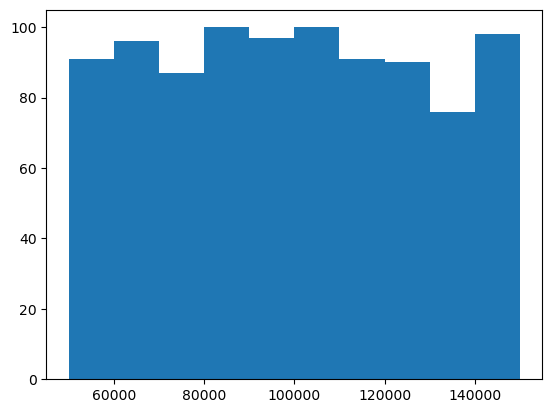

In [12]:
#combo['fake_income'].mean()
plt.hist(combo['fake_income'].values)

0.152
926


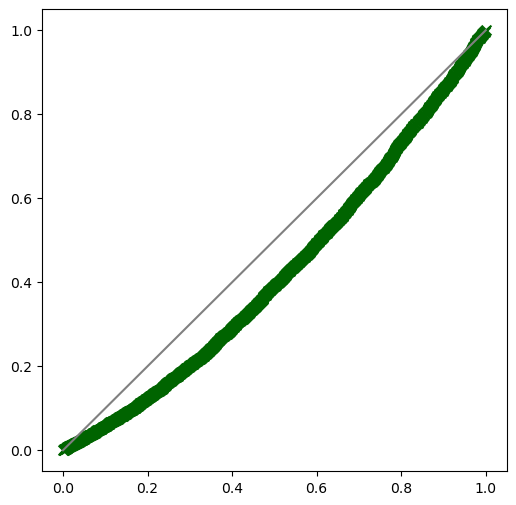

In [13]:
# Test - make one fig & play around
fig, ax = plt.subplots(figsize=[6,6])

# sort values
# example - combo.sort_values(by='E_POV150', ascending=False) # largest to smallest values
test = combo.sort_values(['fake_income']) #per_pov


#tester = tester[tester['E_TOTPOP']>0]
p_y=test['fake_income'].values
p_x=test['E_TOTPOP'].values # try different exposures - exposure, exp_km, exp_per

y = p_y.cumsum() / p_y.sum()
x = p_x.cumsum() / p_x.sum()

ax.scatter(x,y,
            marker='x', color='darkgreen', s=50)

ax.plot([0,1], [0,1], color='gray')
print(round(gini_from_lorenz(y)-gini_from_lorenz(x),3))
print(len(x))

In [14]:
# set font
plt.rcParams["font.family"] = "Arial"

In [15]:
combo.columns

Index(['COUNTY', 'FIPS', 'E_TOTPOP', 'E_POV150', 'E_AGE65', 'E_DISABL',
       'E_MINRTY', 'EP_POV150', 'E_LIMENG', 'RPL_THEME1', 'RPL_THEME2',
       'RPL_THEME3', 'RPL_THEME4', 'SPL_THEME1', 'SPL_THEME2', 'SPL_THEME3',
       'SPL_THEME4', 'SPL_THEMES', 'RPL_THEMES', 'area_100_fzt',
       'area_500_fzt', 'area_min_fzt', 'area_ot_fzt', 'area_fl_tra',
       'area_100_km', 'area_500_km', 'area_min_km', 'area_ot_km', 'area_fl_km',
       'per_fl_100', 'per_fl_500', 'per_fl_min', 'per_fl_ot', 'per_fl_tra',
       'area_tract', 'area_100', 'area_500', 'area_min', 'area_ot', 'exposure',
       'exp_km', 'exp_per', 'per_pov', 'fake_income'],
      dtype='object')

In [16]:
# create exposure columns
# flood exposure = population exposed within census tract (fraction flooded * tract population)
#combo['exp_tot'] = combo['E_TOTPOP']*combo['area_fl_tra']
combo['exp_tot'] = combo['E_TOTPOP']*combo['per_fl_tra']

# get FEMA flood zone (other, 100, 500, min) area per tract, divide by tract area
# multiply by tract population
# combo['exp_ot'] = combo['E_TOTPOP']*(combo['area_ot']/combo['area_tract'])*combo['area_ot_fzt']
# combo['exp_100'] = combo['E_TOTPOP']*(combo['area_100']/combo['area_tract'])*combo['area_100_fzt']
# combo['exp_500'] = combo['E_TOTPOP']*(combo['area_500']/combo['area_tract'])*combo['area_500_fzt']
# combo['exp_min'] = combo['E_TOTPOP']*(combo['area_min']/combo['area_tract'])*combo['area_min_fzt']

combo['exp_ot'] = (combo['E_TOTPOP']*(combo['area_ot']/combo['area_tract']))*(combo['area_ot_fzt']/combo['area_ot'])
combo['exp_100'] = (combo['E_TOTPOP']*(combo['area_100']/combo['area_tract']))*(combo['area_100_fzt']/combo['area_100'])
combo['exp_500'] = (combo['E_TOTPOP']*(combo['area_500']/combo['area_tract']))*(combo['area_500_fzt']/combo['area_500'])
combo['exp_min'] = (combo['E_TOTPOP']*(combo['area_min']/combo['area_tract']))*(combo['area_min_fzt']/combo['area_min'])

In [17]:
combo.fillna(0,inplace=True)

KeyError: 'exp_tot2'

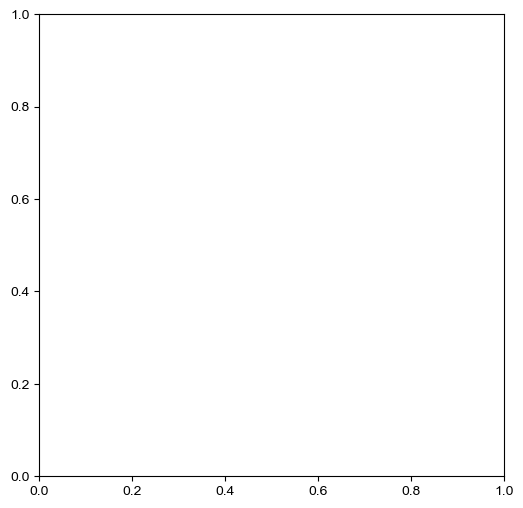

In [18]:
# Test - make one fig & play around
fig, ax = plt.subplots(figsize=[6,6])

# sort values
# example - combo.sort_values(by='E_POV150', ascending=False) # largest to smallest values
test = combo.sort_values(['E_POV150']) #per_pov

#tester = tester[tester['E_TOTPOP']>0]
p_y=test['exp_tot2'].values
p_x=test['E_TOTPOP'].values # try different exposures - exposure, exp_km, exp_per

y = p_y.cumsum() / p_y.sum()
x = p_x.cumsum() / p_x.sum()

ax.scatter(x,y,marker='x', color='darkgreen', s=50)

ax.plot([0,1], [0,1], color='gray')
print(round(gini_from_lorenz(y)-gini_from_lorenz(x),3))
print(len(x))

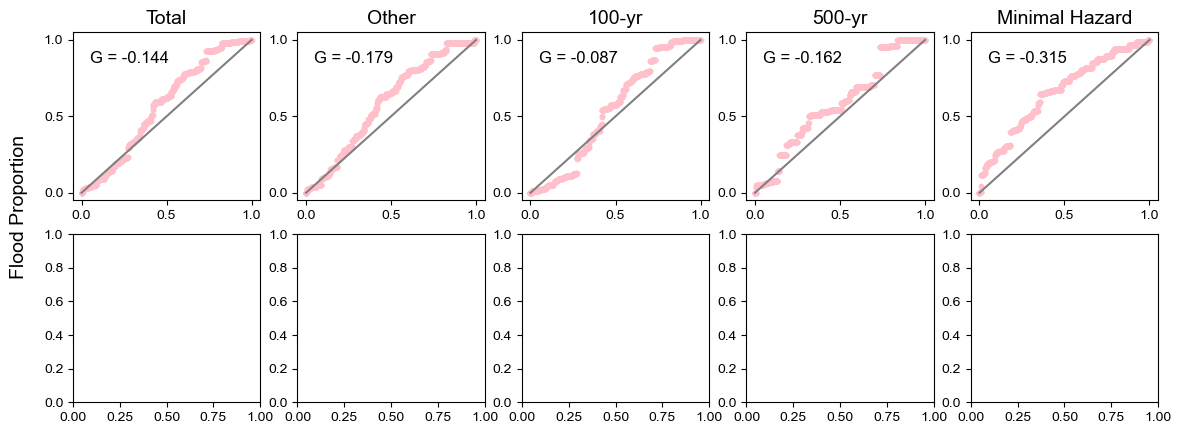

In [19]:
# FIGURE 10
# Lorenz curve - order by poverty

# Create subplots of subnational & hrls & svi themes
flood_exp = ['exp_tot','exp_ot','exp_100','exp_500','exp_min']
sort_val = 'per_pov' #per_pov or E_POV150

# sort dataset
# MUST BE INCREASING VALUES!
sorted = combo.sort_values([sort_val])

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
plt.subplots_adjust(top=.85)
#plt.yticks(np.arange(0, 1, 0.5))

# label y axis
# (x --> bigger is further from plots on the right)
fig.text(.08, 0.5, 'Flood Proportion', va='center', rotation='vertical', fontsize=14)

# label x axis
# fig.text(0.26, .87, 'Total Flood', ha='center', fontsize=14)
# fig.text(0.32, .87, 'Other', ha='center', fontsize=14)
# fig.text(0.50, .87, '100-yr', ha='center', fontsize=14)
# fig.text(0.69, .87, '500-yr', ha='center', fontsize=14)
# fig.text(0.82, .87, 'Minimal Hazard', ha='center', fontsize=14)

# Loop through indices of correlation
for flood_exp, ax in zip(flood_exp, axs.ravel()):   
        
        # get columns
        p_y = sorted[flood_exp].values
        p_x = sorted['E_TOTPOP'].values
        
        # calculate normalized distribution
        x = p_x.cumsum() / p_x.sum()
        y = p_y.cumsum() / p_y.sum()
        
        # plot lorenz curve
        ax.scatter(x, y, marker='o', color='pink', s=10) 
        # plot equality line
        ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        #ax.set_title(f"Type: {flood_exp}")
        ax.text(.05,.85,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
        ax.set_yticks(np.arange(0,1.01,.5))

        # name plots
        if flood_exp == 'exp_tot':
                ax.set_title("Total",fontsize=14)
        elif flood_exp == 'exp_ot':
                ax.set_title("Other",fontsize=14)
        elif flood_exp == 'exp_100':
                ax.set_title("100-yr",fontsize=14)
        elif flood_exp == 'exp_500':
                ax.set_title("500-yr",fontsize=14)
        elif flood_exp == 'exp_min':
                ax.set_title("Minimal Hazard",fontsize=14)

#plt.savefig("pov_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()

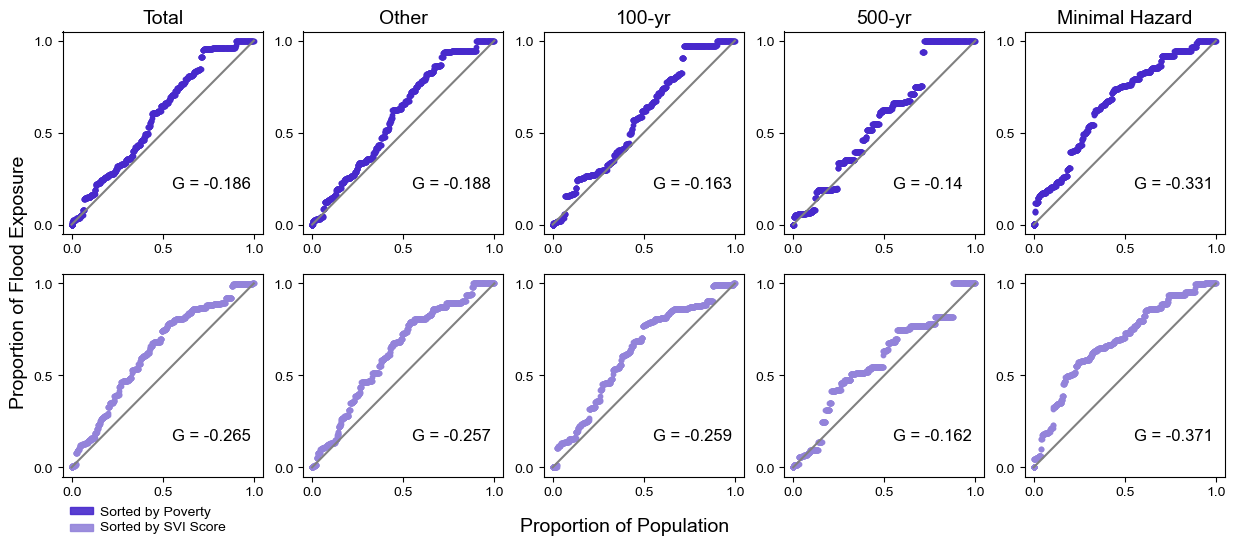

In [20]:
# FIGURE 10
# Lorenz curve - order by poverty

# Create subplots of subnational & hrls & svi themes
flood_exp = ['exp_tot','exp_ot','exp_100','exp_500','exp_min']
sort_val1 = 'E_POV150' #per_pov or E_POV150
sort_val2 = 'SPL_THEMES'

# sort dataset
# MUST BE INCREASING VALUES!
#sorted = combo.sort_values([sort_val])

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
plt.subplots_adjust(top=1)
#plt.yticks(np.arange(0, 1, 0.5))

# label y axis
# (x --> bigger is further from plots on the right)
fig.text(.09, 0.5, 'Proportion of Flood Exposure', va='center', rotation='vertical', fontsize=14)
# fig.text(.09, 0.8, 'Poverty', va='center', rotation='vertical', fontsize=14)
# fig.text(.09, 0.3, 'SVI Score', va='center', rotation='vertical', fontsize=14)

# Legend for sorted variables
#fig.text(0.1, .55, 'Variable Sorted By', va='center', fontsize=12)
fig.patches.extend([plt.Rectangle((0.13,0.035),0.015,0.015, # (x,y) width, height
                                  fill=True, color='#4729cc', alpha=.9, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.15, .04, 'Sorted by Poverty', va='center', fontsize=10)
fig.patches.extend([plt.Rectangle((0.13,0.001),0.015,0.015, # (x,y) width, height
                                  fill=True, color='#9383da', alpha=.9, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.15, .01, 'Sorted by SVI Score', va='center', fontsize=10)

# label x axis
fig.text(0.50, .001, 'Proportion of Population', ha='center', fontsize=14)

# Loop through indices of correlation
for flood_col, ax in zip(flood_exp, axs.ravel()[0:5]):
        #pre_sort = combo[combo['COUNTY']=='Philadelphia']
        sorted = combo.sort_values([sort_val1])

        # get columns
        p_y = sorted[flood_col].values # portion of exposure
        p_x = sorted['E_TOTPOP'].values # portion of population
        
        # calculate normalized distribution
        x = p_x.cumsum() / p_x.sum()
        y = p_y.cumsum() / p_y.sum()
        
        # plot lorenz curve
        ax.scatter(x, y, marker='o', color='#4729cc', s=10) 
        # plot equality line
        ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        ax.set_title(f"{flood_col} sort by {sort_val1}")
        ax.text(.55,.2,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
        ax.set_yticks(np.arange(0,1.01,.5))

        # name plots
        if flood_col == 'exp_tot':
                ax.set_title("Total",fontsize=14)
        elif flood_col == 'exp_ot':
                ax.set_title("Other",fontsize=14)
        elif flood_col == 'exp_100':
                ax.set_title("100-yr",fontsize=14)
        elif flood_col == 'exp_500':
                ax.set_title("500-yr",fontsize=14)
        elif flood_col == 'exp_min':
                ax.set_title("Minimal Hazard",fontsize=14)

for flood_col, ax in zip(flood_exp, axs.ravel()[5:11]):
        sorted = combo.sort_values([sort_val2])

        # get columns
        p_y = sorted[flood_col].values
        p_x = sorted['E_TOTPOP'].values
        
        # calculate normalized distribution
        x = p_x.cumsum() / p_x.sum()
        y = p_y.cumsum() / p_y.sum()
        
        # plot lorenz curve
        ax.scatter(x, y, marker='o', color='#9383da', s=10) 
        # plot equality line
        ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        #ax.set_title(f"{flood_col} sort by {sort_val2}")
        ax.text(.55,.15,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
        ax.set_yticks(np.arange(0,1.01,.5))

#plt.savefig("pov_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Find percent of zone flooded per county

In [ ]:
combo.columns

Index(['COUNTY', 'FIPS', 'E_TOTPOP', 'E_POV150', 'E_AGE65', 'E_DISABL',
       'E_MINRTY', 'EP_POV150', 'E_LIMENG', 'RPL_THEME1', 'RPL_THEME2',
       'RPL_THEME3', 'RPL_THEME4', 'SPL_THEME1', 'SPL_THEME2', 'SPL_THEME3',
       'SPL_THEME4', 'SPL_THEMES', 'RPL_THEMES', 'area_100_fzt',
       'area_500_fzt', 'area_min_fzt', 'area_ot_fzt', 'area_fl_tra',
       'area_100_km', 'area_500_km', 'area_min_km', 'area_ot_km', 'area_fl_km',
       'per_fl_100', 'per_fl_500', 'per_fl_min', 'per_fl_ot', 'per_fl_tra',
       'area_tract', 'area_100', 'area_500', 'area_min', 'area_ot', 'exposure',
       'exp_km', 'exp_per', 'per_pov', 'fake_income', 'exp_tot', 'exp_ot',
       'exp_100', 'exp_500', 'exp_min'],
      dtype='object')

In [21]:
# sum areas by county
dfz = combo.groupby(['COUNTY'])[['area_100_fzt','area_500_fzt', 'area_min_fzt', 'area_ot_fzt',
                                 'area_fl_tra','area_tract', 'area_100', 'area_500', 'area_min', 'area_ot']].sum()
dfz.reset_index(inplace=True)

In [22]:
dfz

,COUNTY,area_100_fzt,area_500_fzt,area_min_fzt,area_ot_fzt,area_fl_tra,area_tract,area_100,area_500,area_min,area_ot
0,Bucks,2.258160e+07,1.823241e+06,1.426155e+07,2.583770e+07,6.458260e+07,1.733619e+10,1.191498e+09,3.061018e+08,1.538606e+10,4.353762e+08
1,Delaware,5.269415e+06,1.215294e+05,7.607087e+05,2.871157e+06,9.213102e+06,5.321207e+09,4.831493e+08,9.731904e+07,4.642995e+09,9.096929e+07
2,Montgomery,1.968423e+07,8.360559e+05,3.220807e+06,2.207950e+07,4.590005e+07,1.358125e+10,5.698788e+08,5.132382e+08,1.214141e+10,3.523262e+08
3,Philadelphia,9.105399e+06,9.016357e+04,7.283387e+05,7.828017e+06,1.775192e+07,3.978852e+09,4.445419e+08,1.527081e+08,3.288176e+09,8.876129e+07


In [23]:
# TABLE 10!!
# get percent flood PER ZONE per county
# the _fzt represents flood per zone per county
# area_ot represents area of zone per county
dfz['per_fl_otz'] = dfz['area_ot_fzt'].div(dfz['area_ot'])*100
dfz['per_fl_100z'] = dfz['area_100_fzt'].div(dfz['area_100'])*100
dfz['per_fl_500z'] = dfz['area_500_fzt'].div(dfz['area_500'])*100
dfz['per_fl_minz'] = dfz['area_min_fzt'].div(dfz['area_min'])*100
#dfz['per_fl_tot'] = dfz['area_fl_tra'].div(dfz['area_tract'])*100
dfz.drop(columns=['area_100_fzt','area_500_fzt', 'area_min_fzt', 'area_ot_fzt',
        'area_fl_tra','area_tract', 'area_100', 'area_500', 'area_min', 'area_ot'], inplace=True)
dfz.head()

,COUNTY,per_fl_otz,per_fl_100z,per_fl_500z,per_fl_minz
0,Bucks,5.934568,1.895228,0.595632,0.092691
1,Delaware,3.156182,1.090639,0.124877,0.016384
2,Montgomery,6.266779,3.454107,0.162898,0.026527
3,Philadelphia,8.819179,2.048266,0.059043,0.022150


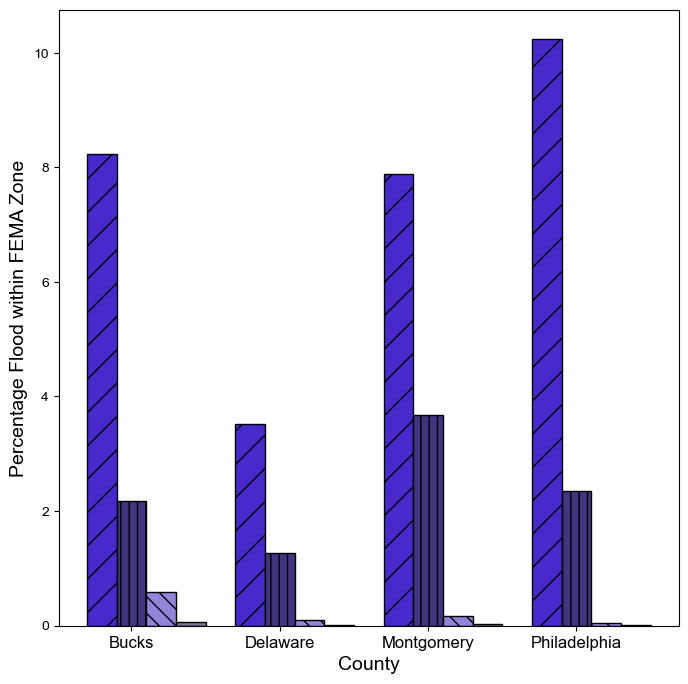

In [ ]:
# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(8, 8)) 

# set height of bar
# fin dataset has the percents
ot = dfz['per_fl_otz']
hun = dfz['per_fl_100z']
fiv = dfz['per_fl_500z']
min = dfz['per_fl_minz']
 
# Set position of bar on X axis 
br1 = np.arange(len(ot)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
 
# Make the plot
plt.bar(br1, ot, color ='#4729cc', width = barWidth, hatch='/',
        edgecolor ='black', label ='Other') 
# error bars
#plt.errorbar(br1, ot, yerr=[1,1,1,1], fmt=".k", color="r")
plt.bar(br2, hun, color ='#423481', width = barWidth, hatch='||',
        edgecolor ='black', label ='100-yr') 
plt.bar(br3, fiv, color ='#9383da', width = barWidth, hatch='\\\\',
        edgecolor ='black', label ='500-yr') 
plt.bar(br4, min, color ='#787390', width = barWidth, hatch='--',
        edgecolor ='black', label ='Minimal Hazard') 
 
# Adding Xticks 

plt.xlabel('County', fontsize = 14) 
plt.ylabel('Percentage Flood within FEMA Zone', fontsize = 14) 
plt.xticks([r + barWidth for r in range(len(hun))], 
        ['Bucks', 'Delaware', 'Montgomery', 'Philadelphia'], fontsize = 12)
#plt.title('Percent Flood in FEMA Zones',fontweight ='bold', fontsize = 18)

#plt.legend(loc='upper left',fontsize=14)
plt.show() 

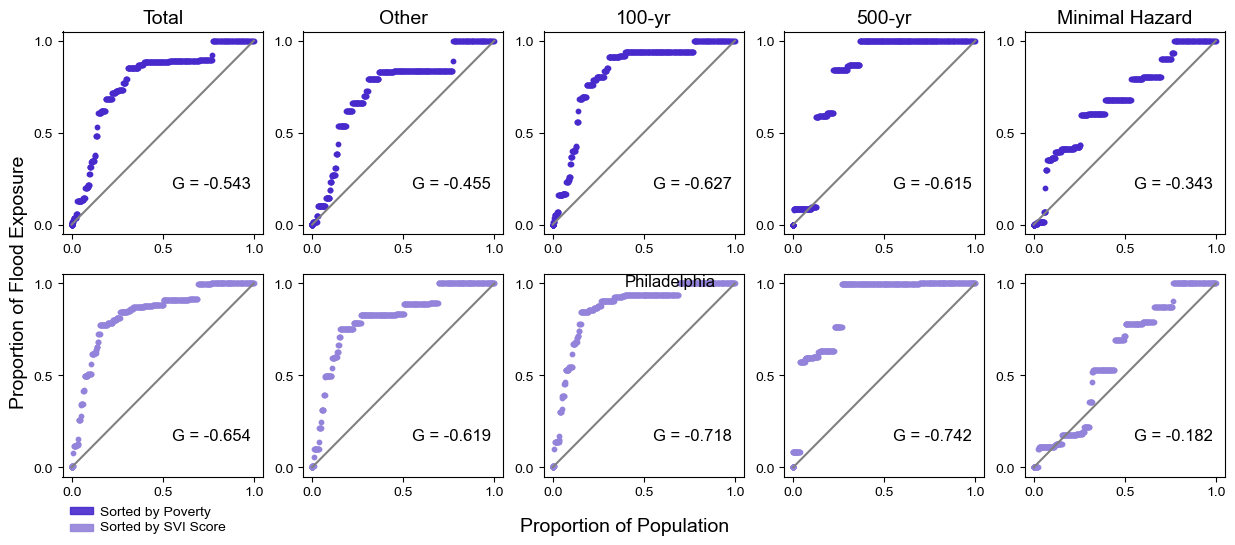

In [ ]:
# FIGURE 10
# Lorenz curve - order by poverty

# Create subplots of subnational & hrls & svi themes
flood_exp = ['exp_tot','exp_ot','exp_100','exp_500','exp_min']
sort_val1 = 'E_POV150' #per_pov or E_POV150
sort_val2 = 'SPL_THEMES'
cnty='Philadelphia'

# sort dataset
# MUST BE INCREASING VALUES!
#sorted = combo.sort_values([sort_val])

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
plt.subplots_adjust(top=1)
#plt.yticks(np.arange(0, 1, 0.5))

# label y axis
# (x --> bigger is further from plots on the right)
fig.text(.09, 0.5, 'Proportion of Flood Exposure', va='center', rotation='vertical', fontsize=14)
#fig.text(.09, 0.8, f'{cnty}', va='center', rotation='vertical', fontsize=14)
# fig.text(.09, 0.3, 'SVI Score', va='center', rotation='vertical', fontsize=14)

# Legend for sorted variables
fig.text(0.5, .5, f'{cnty}', va='center', fontsize=12)
fig.patches.extend([plt.Rectangle((0.13,0.035),0.015,0.015, # (x,y) width, height
                                  fill=True, color='#4729cc', alpha=.9, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.15, .04, 'Sorted by Poverty', va='center', fontsize=10)
fig.patches.extend([plt.Rectangle((0.13,0.001),0.015,0.015, # (x,y) width, height
                                  fill=True, color='#9383da', alpha=.9, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.15, .01, 'Sorted by SVI Score', va='center', fontsize=10)

# label x axis
fig.text(0.50, .001, 'Proportion of Population', ha='center', fontsize=14)

# Loop through indices of correlation
for flood_col, ax in zip(flood_exp, axs.ravel()[0:5]):
        pre_sort = combo[combo['COUNTY']==cnty]
        sorted = pre_sort.sort_values([sort_val1])

        # get columns
        p_y = sorted[flood_col].values # portion of exposure
        p_x = sorted['E_TOTPOP'].values # portion of population
        
        # calculate normalized distribution
        x = p_x.cumsum() / p_x.sum()
        y = p_y.cumsum() / p_y.sum()
        
        # plot lorenz curve
        ax.scatter(x, y, marker='o', color='#4729cc', s=10) 
        # plot equality line
        ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        #ax.set_title(f"Type: {flood_exp}")
        ax.text(.55,.2,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
        ax.set_yticks(np.arange(0,1.01,.5))

                # name plots
        if flood_col == 'exp_tot':
                ax.set_title("Total",fontsize=14)
        elif flood_col == 'exp_ot':
                ax.set_title("Other",fontsize=14)
        elif flood_col == 'exp_100':
                ax.set_title("100-yr",fontsize=14)
        elif flood_col == 'exp_500':
                ax.set_title("500-yr",fontsize=14)
        elif flood_col == 'exp_min':
                ax.set_title("Minimal Hazard",fontsize=14)

for flood_col, ax in zip(flood_exp, axs.ravel()[5:11]):
        pre_sort = combo[combo['COUNTY']==cnty]
        sorted = pre_sort.sort_values([sort_val2])

        # get columns
        p_y = sorted[flood_col].values
        p_x = sorted['E_TOTPOP'].values
        
        # calculate normalized distribution
        x = p_x.cumsum() / p_x.sum()
        y = p_y.cumsum() / p_y.sum()
        
        # plot lorenz curve
        ax.scatter(x, y, marker='o', color='#9383da', s=10) 
        # plot equality line
        ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        #ax.set_title(f"Type: {flood_exp}")
        ax.text(.55,.15,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
        ax.set_yticks(np.arange(0,1.01,.5))

#plt.savefig("pov_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()


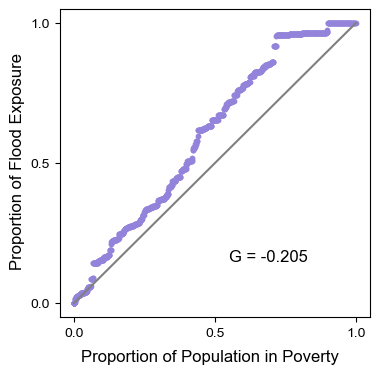

In [ ]:
# one plot for finnesst

flood_exp = ['exp_tot','exp_ot','exp_100','exp_500','exp_min']
sort_val1 = 'E_POV150' #per_pov or E_POV150
sort_val2 = 'SPL_THEMES'
#cnty='Philadelphia'

# sort dataset
# MUST BE INCREASING VALUES!
#sorted = combo.sort_values([sort_val])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
#plt.subplots_adjust(top=1)
#plt.yticks(np.arange(0, 1, 0.5))

# label y axis
# (x --> bigger is further from plots on the right)
fig.text(.0003, 0.5, 'Proportion of Flood Exposure', va='center', rotation='vertical', fontsize=12)
# x axis
fig.text(0.50, .0003, 'Proportion of Population in Poverty', ha='center', fontsize=12)

# make plot
pre_sort = combo #combo[combo['COUNTY']==cnty]
sorted = pre_sort.sort_values([sort_val1])

# get columns
p_y = sorted['exp_tot'].values
p_x = sorted['E_TOTPOP'].values
        
# calculate normalized distribution
x = p_x.cumsum() / p_x.sum()
y = p_y.cumsum() / p_y.sum()
        
# plot lorenz curve
ax.scatter(x, y, marker='o', color='#9383da', s=10) 
        # plot equality line
ax.plot([0,1], [0,1], color='gray')
        
        # plot gini index
        #ax.set_title(f"Type: {flood_exp}")
ax.text(.55,.15,f'G = {round(gini_from_lorenz(y)-gini_from_lorenz(x),3)}',fontsize=12)
ax.set_yticks(np.arange(0,1.001,.5))
ax.set_xticks(np.arange(0,1.001,.5))

plt.show()